In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [293]:
from typing import List, Dict
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize

import openai

from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW, get_cosine_schedule_with_warmup, GPT2Config, GenerationConfig
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from textblob import TextBlob
from nltk import bigrams, trigrams
import torch

from rouge import Rouge

from nltk.translate.bleu_score import sentence_bleu
from torch.nn.functional import softmax


from peft import AutoPeftModelForCausalLM
from datasets import load_dataset, Dataset
from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from llama2_finetuning.prepare_data_llama import split_window_and_tokenize as llama_split_window_and_tokenize

In [2]:
# data_folder = '/content/drive/Shareddrives/AAI520-Final-Project/data/'
# Or if running locally:
data_folder = '../data/ubuntu/'

In [3]:
# Load the data
train_df = pd.read_csv(data_folder + 'train.csv')
test_df = pd.read_csv(data_folder + 'test.csv')
val_df = pd.read_csv(data_folder + 'valid.csv')

## Some example code that will need to be adjusted based on the dataset and model we choose

In [29]:
# Explore the data
train_df.head()

,Context,Utterance,Label
0,i think we could import the old comments via r...,yes. same binary packages. __eou__,1.0
1,I'm not suggesting all - only the ones you mod...,ok let me try that.. thanks man __eou__,0.0
2,afternoon all __eou__ not entirely related to ...,http://www.ubuntu.com/download/ -- any mirror ...,0.0
3,interesting __eou__ grub-install worked with /...,i fully endorse this suggestion </quimby> __eo...,1.0
4,and because Python gives Mark a woody __eou__ ...,ok if youre DefaultDepth 24 __eou__,0.0


In [4]:
# Find the mean length of ground truth utterances in the validation set
val_df['Ground Truth Utterance'].apply(len).mean()

91.82055214723927

In [5]:
# Explore the data
train_df['Label'].value_counts()

Label
0.0    500500
1.0    499500
Name: count, dtype: int64

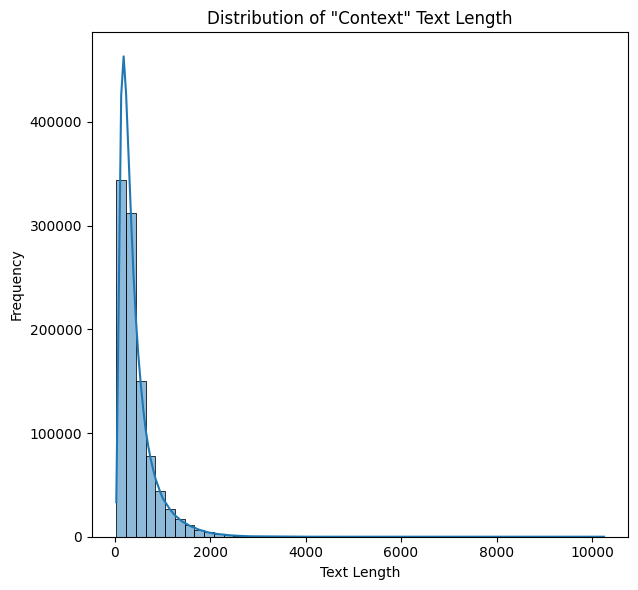

In [4]:
# Calculate the length of each text entry in the 'Context'
train_df['Context_length'] = train_df['Context'].apply(len)

# Create visualizations to understand the distribution of text length
plt.figure(figsize=(12, 6))

# Subplot for 'Context_length'
plt.subplot(1, 2, 1)
sns.histplot(train_df['Context_length'], bins=50, kde=True)
plt.title('Distribution of "Context" Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# Calculate the number of contexts longer than 768 in train_df
long_contexts = train_df[train_df['Context_length'] > 768]
len(long_contexts)

141718

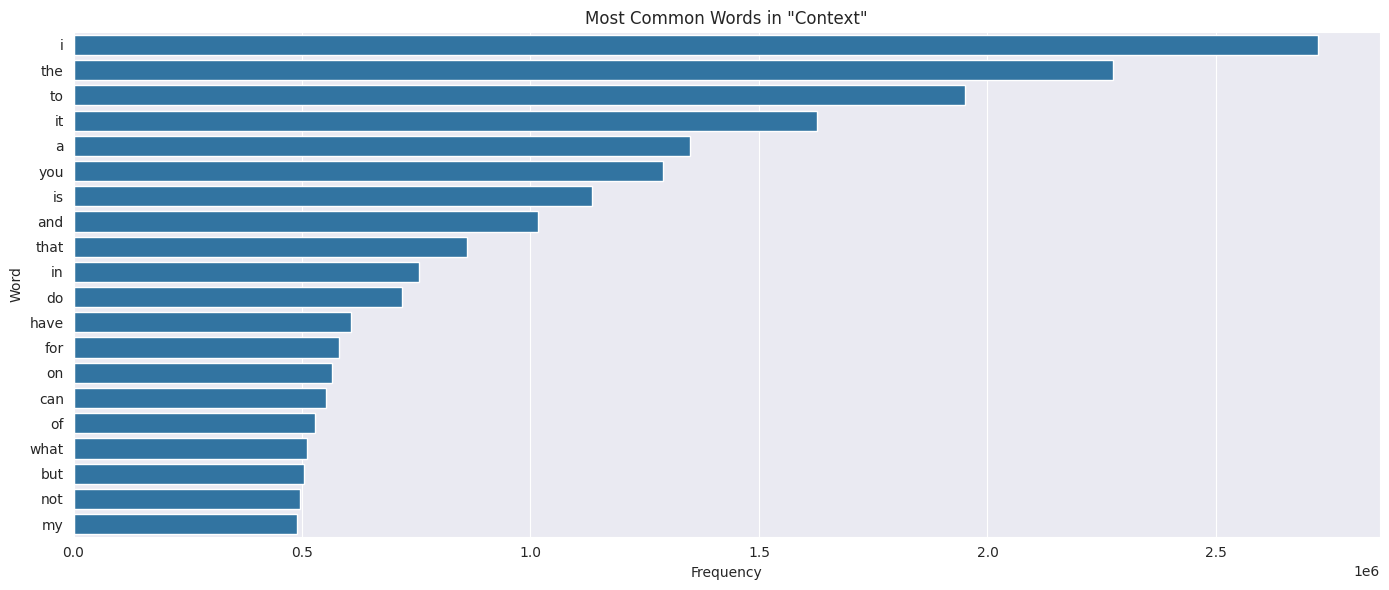

In [24]:
# Tokenize the words in 'Context' 
context_words = ' '.join(train_df['Context']).lower()
context_tokens = word_tokenize(context_words)

# Filter out the end-of-utterance and end-of-turn tokens
filtered_tokens = [token for token in context_tokens if token not in ['__eou__', '__eot__']]

# Filter out punctuation
filtered_tokens = [token for token in filtered_tokens if re.match(r'[^\W\d]*$', token)]

# Count the frequency of each word
context_word_freq = Counter(filtered_tokens)

# Get the 20 most common words in 'Context' 
common_words_context = context_word_freq.most_common(20)

# Create plots for the most common words
plt.figure(figsize=(14, 6))

# Subplot for 'Context'
sns.barplot(x=[count for word, count in common_words_context], y=[word for word, count in common_words_context])
plt.title('Most Common Words in "Context"')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()

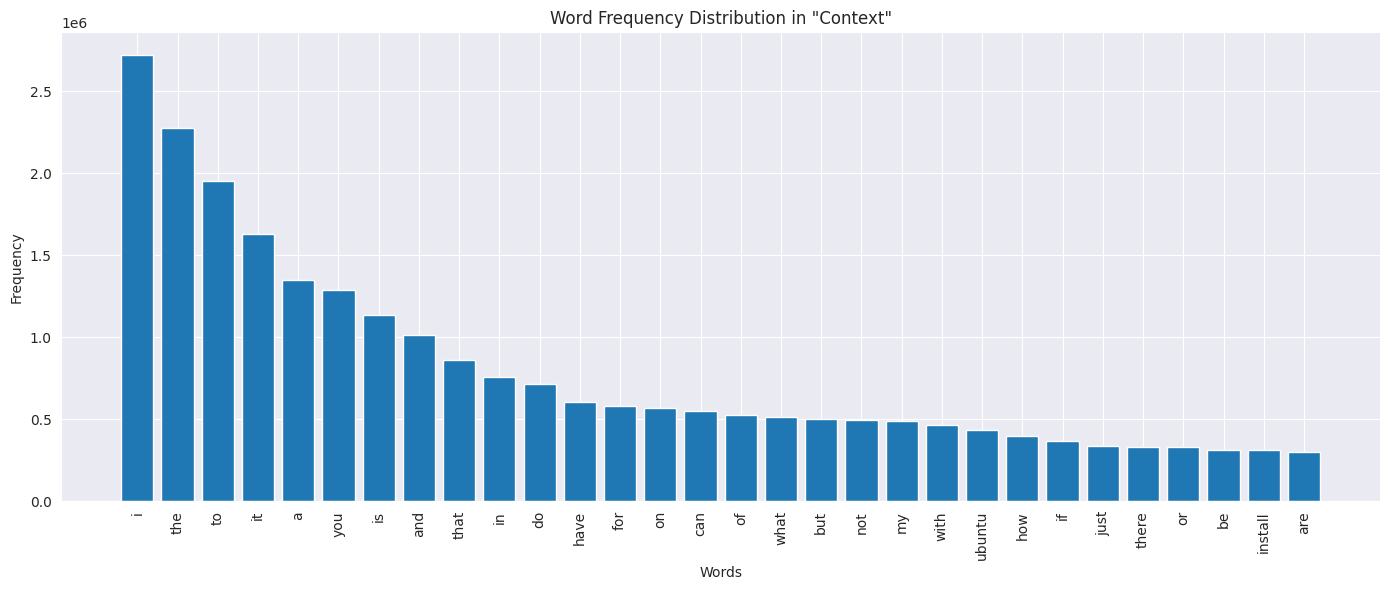

In [25]:
# Convert Counter objects to lists for plotting
context_word_freq_list = sorted(context_word_freq.items(), key=lambda x: x[1], reverse=True)

# Create subplots
plt.figure(figsize=(14, 6))

# Subplot for 'Context'
plt.bar(range(30), [freq for word, freq in context_word_freq_list[:30]], tick_label=[word for word, freq in context_word_freq_list[:30]])
plt.xticks(rotation=90)
plt.title('Word Frequency Distribution in "Context"')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

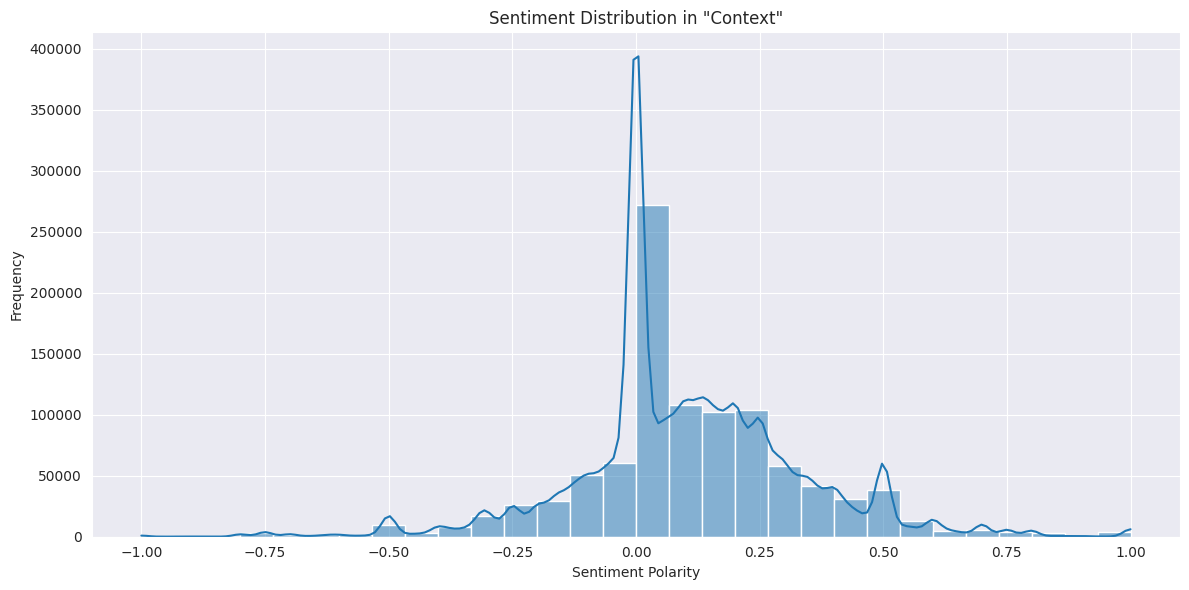

In [21]:
# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply the function to 'Context'
train_df['Context_Sentiment'] = train_df['Context'].apply(get_sentiment)

# Visualize the sentiment distribution
plt.figure(figsize=(12, 6))

# plot for 'Context_Sentiment'
sns.histplot(train_df['Context_Sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution in "Context"')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

In [ ]:
# Calculate and plot the most common bigrams in 'Context'

# Get the bigrams
context_bigrams = list(bigrams(filtered_tokens))

# Count the frequency of each bigram
context_bigram_freq = Counter(context_bigrams)

# Get the 20 most common bigrams
common_bigrams_context = context_bigram_freq.most_common(20)

In [27]:
# Print the most common bigrams
common_bigrams_context

[(('i', 'have'), 233537),
 (('i', 'do'), 150750),
 (('do', 'i'), 144339),
 (('in', 'the'), 143538),
 (('do', 'you'), 125931),
 (('if', 'you'), 119456),
 (('i', 'can'), 117203),
 (('want', 'to'), 112666),
 (('you', 'can'), 112541),
 (('but', 'i'), 112056),
 (('how', 'do'), 110488),
 (('can', 'i'), 108379),
 (('on', 'the'), 107136),
 (('need', 'to'), 105134),
 (('when', 'i'), 101484),
 (('is', 'there'), 99458),
 (('it', 'is'), 98980),
 (('how', 'to'), 98422),
 (('you', 'have'), 97424),
 (('have', 'a'), 97386)]

In [29]:
# Find and print the most common tri-gams in 'Context'

# Get the tri-grams
context_trigrams = list(trigrams(filtered_tokens))

# Count the frequency of each tri-gram
context_trigram_freq = Counter(context_trigrams)

# Get the 20 most common tri-grams
common_trigrams_context = context_trigram_freq.most_common(20)
common_trigrams_context

[(('how', 'do', 'i'), 95206),
 (('how', 'can', 'i'), 62078),
 (('is', 'there', 'a'), 49912),
 (('i', 'want', 'to'), 46792),
 (('i', 'have', 'a'), 46035),
 (('i', 'need', 'to'), 39811),
 (('know', 'how', 'to'), 33235),
 (('you', 'need', 'to'), 32009),
 (('do', 'you', 'have'), 30818),
 (('you', 'want', 'to'), 28741),
 (('i', 'have', 'to'), 27021),
 (('i', 'do', 'know'), 26824),
 (('be', 'able', 'to'), 25702),
 (('a', 'way', 'to'), 25107),
 (('what', 'is', 'the'), 24627),
 (('there', 'a', 'way'), 22579),
 (('does', 'anyone', 'know'), 22424),
 (('what', 'do', 'you'), 21995),
 (('you', 'have', 'to'), 20784),
 (('i', 'trying', 'to'), 20595)]

In [31]:
# Explore the test data
test_df.head()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
0,anyone knows why my stock oneiric exports env ...,https://bugs.launchpad.net/lightdm/+bug/864109...,12.04 is out now. __eou__ ppa's are commonly...,The SMART information is stored in the control...,its still 12.04 LTS in details shouldnt it be ...,persist? it is set correctly after boot. but t...,can i help you in any way? __eou__,"do you find ia32-libs-multiarch is installed,...","okay, thanks. I've ended up with an odd situa...",did that work? __eou__,"there is a variable PATH (run ""echo $PATH"") wh..."
1,i set up my hd such that i have to type a pass...,installing from source on ubuntu isn't a great...,OK __eou__,"Yeah, if you want to claim that. It's kinda co...",like for me you could type his<tab> should au...,ahh ok __eou__,bleurgh .. openvpn instead of ssh :) __eou__ w...,"it's a perl script, just text, right? __eou__",http://www.noah.org/wiki/Single_User_Mode __eou__,heres a easy manual about the setup on Win htt...,first place I looked __eou__
2,im trying to use ubuntu on my macbook pro reti...,just wondering how it runs __eou__,hmm ok by doing apt-get autoremove it removed ...,"What's an ""m/c""? __eou__","jamezq, under /etc __eou__ thanks __eou__ yes ...",yeah seems like a reasonable way to go ^_^ __e...,why do you not already have one? __eou__,if you need the data do NOT PUT POWER back on ...,ok __eou__,i'd just clean install then. Restore user data...,backports are a repo you can enable in your pa...
3,no suggestions? __eou__ links? __eou__ how can...,that leads me to the next question lol... i do...,"I'm not sure, but if you're able to pastbin th...",you can adjust it with hdparm __eou__ I recomm...,Works here __eou__,What sort of themes do I need to download to u...,thanks __eou__,https://help.ubuntu.com/community/Installation...,"I just noticed this package in the repos, so i...",wine can detect the CD but I have to manually ...,you could re-encode it with mencoder or ffmpeg...
4,I just added a second usb printer but not sure...,firefox? __eou__,fair enough then __eou__,"was anyone in the ""admin"" group? __eou__",431? udp syslog is 514... __eou__,not yet __eou__,"ah, I just have to install virtualbox-guest-x1...",i thought of that but ive looked at one of the...,ok. thanks. i sent him in an email the command...,"there you go, now your name pops up in yellow ...","if that were the case, they why on earth would..."


In [30]:
train_df['Context'][0]

"i think we could import the old comments via rsync, but from there we need to go via email. I think it is easier than caching the status on each bug and than import bits here and there __eou__ __eot__ it would be very easy to keep a hash db of message-ids  __eou__ sounds good __eou__ __eot__ ok __eou__ perhaps we can ship an ad-hoc apt_prefereces __eou__ __eot__ version? __eou__ __eot__ thanks __eou__ __eot__ not yet __eou__ it is covered by your insurance? __eou__ __eot__ yes __eou__ but it's really not the right time :/ __eou__ with a changing house upcoming in 3 weeks __eou__ __eot__ you will be moving into your house soon? __eou__ posted a message recently which explains what to do if the autoconfiguration does not do what you expect __eou__ __eot__ how urgent is #896? __eou__ __eot__ not particularly urgent, but a policy violation __eou__ __eot__ i agree that we should kill the -novtswitch __eou__ __eot__ ok __eou__ __eot__ would you consider a package split a feature? __eou__ __

In [4]:
# Remove whitespace from end of Context and Utterance
train_df['Context'] = train_df['Context'].apply(lambda x: x.strip())
train_df['Utterance'] = train_df['Utterance'].apply(lambda x: x.strip())

In [5]:
val_df['Context'] = val_df['Context'].apply(lambda x: x.strip())
val_df['Ground Truth Utterance'] = val_df['Ground Truth Utterance'].apply(lambda x: x.strip())

In [6]:
test_df['Context'] = test_df['Context'].apply(lambda x: x.strip())
test_df['Ground Truth Utterance'] = test_df['Ground Truth Utterance'].apply(lambda x: x.strip())

In [7]:
# check that the last token of every context is __eot__
num_train_context_not_eot = 0
for context in train_df['Context']:
    if not context.endswith('__eot__'):
        num_train_context_not_eot += 1

num_val_context_not_eot = 0
for context in val_df['Context']:
    if not context.endswith('__eot__'):
        num_val_context_not_eot += 1
        
num_test_context_not_eot = 0
for context in test_df['Context']:
    if not context.endswith('__eot__'):
        num_test_context_not_eot += 1
        
print("Number of train contexts not ending with __eot__:", num_train_context_not_eot)
print("Number of val contexts not ending with __eot__:", num_val_context_not_eot)
print("Number of test contexts not ending with __eot__:", num_test_context_not_eot)

Number of train contexts not ending with __eot__: 0
Number of val contexts not ending with __eot__: 0
Number of test contexts not ending with __eot__: 0


In [8]:
# Add __eot__ to the end of the Ground Truth Utterance and Utterances
train_df['Utterance'] = train_df['Utterance'] + ' __eot__'
val_df['Ground Truth Utterance'] = val_df['Ground Truth Utterance'] + ' __eot__'
test_df['Ground Truth Utterance'] = test_df['Ground Truth Utterance'] + ' __eot__'

In [9]:
# check that the last token of every Utterance is __eot__
num_train_utterances_not_eot = 0
for context in train_df['Utterance']:
    if not context.endswith('__eot__'):
        num_train_utterances_not_eot += 1

num_val_utterances_not_eot = 0
for context in val_df['Ground Truth Utterance']:
    if not context.endswith('__eot__'):
        num_val_utterances_not_eot += 1
        
num_test_utterances_not_eot = 0
for context in test_df['Ground Truth Utterance']:
    if not context.endswith('__eot__'):
        num_test_utterances_not_eot += 1
        
print("Number of train utterances not ending with __eot__:", num_train_utterances_not_eot)
print("Number of val utterances not ending with __eot__:", num_val_utterances_not_eot)
print("Number of test utterances not ending with __eot__:", num_test_utterances_not_eot)

Number of train utterances not ending with __eot__: 0
Number of val utterances not ending with __eot__: 0
Number of test utterances not ending with __eot__: 0


In [10]:
# Create training data for generation, only save data if label = 1
train_gen_df = train_df[train_df['Label'] == 1].copy()
train_text_context = train_gen_df['Context'].astype(str).tolist()
train_text_utterance = train_gen_df['Utterance'].astype(str).tolist()

In [11]:
# Create validation data for generation
val_text_context = val_df['Context'].astype(str).tolist()
val_text_ground_truth = val_df['Ground Truth Utterance'].astype(str).tolist()

# Create test data for generation
test_text_context = test_df['Context'].astype(str).tolist()
test_text_ground_truth = test_df['Ground Truth Utterance'].astype(str).tolist()

In [12]:
train_text_context[11230]

"is there a way to edit menus in hoary? __eou__ I installed k3b and now I have some crappy kde stuff  in the applications menu __eou__ __eot__ there is no way to edit menus in hoary (except compiling kmenuedit from KDE 3.4) __eou__ what is in the menu that you don't want? __eou__ __eot__ the control center for kde __eou__ __eot__ where does that appear, could you give me a screenshot? (we're putting together new KDE packages so may be able to fix it) __eou__ __eot__"

In [14]:
train_text_utterance[11230]

"I'll give you a link to the screenshot in a min __eou__ well actually I can't take a screenshot with the applications or any other menu pulled down __eou__ __eot__"

In [14]:
val_text_context[234]

"does anyone else have a problem that alt-tab stops working and just shakes the icons? I need to click the dock with my mouse to change focus! __eou__ it happens all the time! this is on top of resizing being broken! WTF! __eou__ __eot__ You can force the icons to wiggle? That's really cute. __eou__ Why do you say this __eou__ Get out if you hate Ubuntu __eou__ __eot__ because I'm upset, and eff you __eou__ __eot__"

In [15]:
val_text_ground_truth[234]

'Cry me a river, buddy. Use another os. __eou__ __eot__'

In [16]:
test_text_context[5152]

'who can help a linux noob pls? __eou__ __eot__ just ask __eou__ is there a GUI you could use maybe (assuming you have a desktop UI) __eou__ makes sense __eou__ http://www.linuxquestions.org/questions/linux-security-4/how-to-blocking-a-website-with-iptables-603071/ __eou__ __eot__'

In [17]:
test_text_ground_truth[5152]

'thanx im gonna check it out, ive already looked on the web but when I put the rules they dont work at all, but im gonna check that site __eou__ __eot__'

In [12]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large', padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [85]:
def add_tokens_to_lists(input_lists, input_ids):
    input_lists['input_ids'].append(torch.tensor(input_ids))
    input_lists['attention_masks'].append(torch.ones(len(input_ids)))
    
    return input_lists

def get_last_turn(token_ids, eot_id):
    # Find the last turn
    eot_positions = [pos for pos, token_id in enumerate(token_ids) if token_id == eot_id]
    start_of_last_turn_pos = eot_positions[-2] + 1
        
    return token_ids[:start_of_last_turn_pos], token_ids[start_of_last_turn_pos:]

In [14]:
tokenizer.special_tokens_map

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [88]:
# test filtering last turn
token_ids = tokenizer.encode('hello how are you <|endoftext|> i\'m good <|endoftext|> thats great to hear, i am good too <|endoftext|>')
eot_id = tokenizer.convert_tokens_to_ids('<|endoftext|>')

filtered_token_ids, second = get_last_turn(token_ids, eot_id)
print(tokenizer.decode(filtered_token_ids))
print(tokenizer.decode(second))

hello how are you <|endoftext|> i'm good <|endoftext|>
 thats great to hear, i am good too <|endoftext|>


In [16]:
# Replace all __eot__ strings with <|endoftext|>
train_text_context = [text.replace('__eot__', '<|endoftext|>') for text in train_text_context]
train_text_utterance = [text.replace('__eot__', '<|endoftext|>') for text in train_text_utterance]
val_text_context = [text.replace('__eot__', '<|endoftext|>') for text in val_text_context]
val_text_ground_truth = [text.replace('__eot__', '<|endoftext|>') for text in val_text_ground_truth]
test_text_context = [text.replace('__eot__', '<|endoftext|>') for text in test_text_context]
test_text_ground_truth = [text.replace('__eot__', '<|endoftext|>') for text in test_text_ground_truth]

In [17]:
def split_window_and_tokenize(contexts, utterances, max_length, eot_id, test_set=False):
    input_ids_list = []
    attention_mask_list = []
    lists_of_ids = {
        'input_ids': input_ids_list, 
        'attention_masks': attention_mask_list
    }
    current_context = 0
    
    for context, utterance in zip(contexts, utterances):
        current_context += 1
        if current_context % 1000 == 0:
            print(f'\rProcessing context {current_context} of {len(contexts)}...', end='', flush=True)
        # Combine context and utterance, then tokenize
        combined_text = context + utterance
        
        # filter out _eou_ strings
        combined_text = combined_text.replace('__eou__', '')
        
        # tokenize text
        token_ids = tokenizer.encode(combined_text)
 
        # find all the eot positions
        eot_positions = [pos for pos, token_id in enumerate(token_ids) if token_id == eot_id]
        
        if len(token_ids) <= max_length:           
            # if the sequence is shorter than the max length, just add it, with input being up to the second to last eot
            new_input_ids = token_ids.copy()
            
            lists_of_ids = add_tokens_to_lists(lists_of_ids, new_input_ids)
        else:
            # if sequence is longer than max length, split into windows
            seq_start = 0  # Start index of the current sequence
            previous_seq_length = len(token_ids)  # Initialize with the full length

            # look at eot_positions to find the last eot that is within the max length
            while len(token_ids[seq_start:]) > max_length:
                eots_within_limit = [eot_pos for eot_pos in eot_positions if (eot_pos - seq_start) <= (max_length - 1)]
                if len(eots_within_limit) > 1:        
                    new_input_ids = token_ids[seq_start:eots_within_limit[-1] + 1].copy()
                    lists_of_ids = add_tokens_to_lists(lists_of_ids, new_input_ids)
                    
                    # now set the start of the next sequence to the start of the second turn, and check again
                    seq_start = eots_within_limit[0] + 2
                    eot_positions = [eot_pos for eot_pos in eot_positions if eot_pos > seq_start]  # Adjust the eot_positions
                else:
                    # Only proceed if there are remaining EOT positions to consider
                    if len(eot_positions) > 1:
                        seq_start = eot_positions[0] + 2
                        eot_positions = [eot_pos for eot_pos in eot_positions if eot_pos > seq_start]  # Adjust the eot_positions
                    else:
                        # Not enough EOT positions, break out of the while loop
                        print(f'Too few turns left in sequence. Breaking loop. Number of turns: {len(eot_positions)}')
                        break
                if len(token_ids[seq_start:]) == previous_seq_length:
                    print(f'Warning: Loop is not breaking. Previous sequence length: {previous_seq_length}, current sequence length: {len(token_ids[seq_start:])}')
                    break
                previous_seq_length = len(token_ids[seq_start:])

    return lists_of_ids

In [18]:
max_length = 1024

train_list = split_window_and_tokenize(train_text_context, train_text_utterance, max_length, eot_id)

Processing context 23000 of 499500...

Token indices sequence length is longer than the specified maximum sequence length for this model (1139 > 1024). Running this sequence through the model will result in indexing errors


Processing context 216000 of 499500...Too few turns left in sequence. Breaking loop. Number of turns: 1
Processing context 499000 of 499500...

In [19]:
val_list = split_window_and_tokenize(val_text_context, val_text_ground_truth, max_length, eot_id)

Processing context 16000 of 18920...Too few turns left in sequence. Breaking loop. Number of turns: 1
Processing context 18000 of 18920...

In [ ]:
test_list = split_window_and_tokenize(test_text_context, test_text_ground_truth, max_length, eot_id)

In [20]:
train_encodings = {
    'input_ids': train_list['input_ids'],
    'attention_mask': train_list['attention_masks'],
}

val_encodings = {
    'input_ids': val_list['input_ids'],
    'attention_mask': val_list['attention_masks']
}

test_encodings = {
    'input_ids': test_list['input_ids'],
    'attention_mask': test_list['attention_masks']
}

In [21]:
# print a couple of input_ids decoded
for input_ids in train_encodings['input_ids'][319449:319451]:
    print(tokenizer.decode(input_ids, skip_special_tokens=False))
    print('\n\n')

hey, anyone tried triple boot with wubi?  anyone tried tripleboot with wubi on a macbook?  <|endoftext|>  wubi + Windows Installer for Ubuntu  <|endoftext|>How do you mean? did you install it next to os x?  <|endoftext|>



hi, i'm trying to configure keyboard, but dpkg-reconfigure xserver-xorg does nothing. is that normal?  <|endoftext|> i dont think that is used anymore,  X -configure is the new way  <|endoftext|> what does it do? will it overwrite my xorg.conf?  <|endoftext|> i dont think xorg.conf is used any more in /etc/X11  it creates a file in /home/user  <|endoftext|> thanks! i'll try  <|endoftext|>for more info check out x.org  you have to stop services for gdm and then restart after you reconfigure  <|endoftext|>


In [22]:
# check max length of input_ids
max_len = 0
for input_ids in train_encodings['input_ids']:
    if len(input_ids) > max_len:
        max_len = len(input_ids)
        
print("Max length of input_ids:", max_len)

Max length of input_ids: 1024


In [23]:
# Print sample of val input_ids
for input_ids in val_encodings['input_ids'][200:202]:
    print(tokenizer.decode(input_ids, skip_special_tokens=False))
    print('\n\n')

Is booting with an encrypted disk and btrfs filesystem supported again in 12.04?  <|endoftext|> encrypted /home is, and btrfs is... not sure about together, but i'd assume yes  <|endoftext|>I'll have a try and see. I used to work in ubuntu, then some random changes fibered it.  <|endoftext|>



how hard is it to use multiple graphics cards? (I need more screen outputs.) are there any requirements on the graphics cards, or can I pick two arbitrarily? ie. will an ati card work with a nvidia card?  <|endoftext|> ati + nvidia = no go  even only ati is a no-go :')  <|endoftext|>so what is required to use several graphics cards?  <|endoftext|>


In [24]:
# check number of input_ids and target_ids
print("Number of input_ids:", len(train_encodings['input_ids']))
# print("Number of target_ids:", len(train_targets['input_ids']))

Number of input_ids: 499529


In [25]:
# check number of input_ids and target_ids
print("Number of input_ids:", len(train_encodings['input_ids']))

Number of input_ids: 499529


In [26]:
# check max length of val_encodings
max_len = 0
for input_ids in val_encodings['input_ids']:
    if len(input_ids) > max_len:
        max_len = len(input_ids)
        
print("Max length of val_encodings:", max_len)

Max length of val_encodings: 982


In [28]:
# Save the tokenized train data
torch.save(train_encodings, data_folder + 'train_encodings_large.pt')

In [29]:
# Save the tokenized validation and test data
torch.save(val_encodings, data_folder + 'val_encodings_large.pt')

torch.save(test_encodings, data_folder + 'test_encodings_large.pt')

In [31]:
# Save the tokenizer
tokenizer.save_pretrained(data_folder + 'tokenizer_large')

('../data/ubuntu/tokenizer_large/tokenizer_config.json',
 '../data/ubuntu/tokenizer_large/special_tokens_map.json',
 '../data/ubuntu/tokenizer_large/vocab.json',
 '../data/ubuntu/tokenizer_large/merges.txt',
 '../data/ubuntu/tokenizer_large/added_tokens.json',
 '../data/ubuntu/tokenizer_large/tokenizer.json')

## Fine-tuning of the model was done using scripts due to Colab memory limitations

Dialo-Medium & Large training script found [here](https://github.com/jeffreykthomas/AAI-520-Final-Project/blob/main/gpt2_finetuning/gpt2_generator_train.py)

Llama2 training script found [here](https://github.com/jeffreykthomas/AAI-520-Final-Project/blob/main/llama2_finetuning/llama2_train.py)

# Evaluation

In [3]:
# Load the tokenized test data (if not already loaded)
# This data is used because it has been formatted to be less than 1024 tokens
test_encodings = torch.load(data_folder + 'test_encodings.pt')

In [215]:
#BLEU SCORE

def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

#ROUGE SCORE

def calculate_rouge(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=True)
    return scores

def calculate_perplexity(model, tokenizer, data_loader):
    model.eval()  # set model to evaluation mode
    batch_num = 0
    nlls = []
    
    for (inputs, target) in data_loader:
        batch_num += 1
        print(f'\rProcessing batch {batch_num} of {len(data_loader)}...', end='', flush=True)
        # concatenate the context and utterance
        inputs = inputs + ' ' + target
        tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        
        b_inputs = tokenized_inputs['input_ids'].to(device)
        b_attention_masks = tokenized_inputs['attention_mask'].to(device)
        target = tokenized_inputs['input_ids'].to(device)
        seq_len = b_inputs.size(1)
        stride = 512
        prev_end_loc = 0
        
        for begin_loc in range(0, seq_len, stride):
            end_loc = min(begin_loc + max_length, seq_len)
            trg_len = end_loc - prev_end_loc
            input_ids = b_inputs[:, begin_loc:end_loc]
            attention_masks = b_attention_masks[:, begin_loc:end_loc]
            target_ids = target[:, begin_loc:end_loc]
            
            target_ids[:, :-trg_len] = -100
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_masks, labels=target_ids)
                neg_log_likelihood = outputs.loss
                nlls.append(neg_log_likelihood)
            
            prev_end_loc = end_loc
            
    # Calculate the perplexity
    perplexity = torch.exp(torch.stack(nlls).mean())
    
    return perplexity

In [164]:
# Calculate BLEU
def get_average_evaluation_scores(references, generated_responses):
    total_bleu = 0
    for reference, candidate in zip(references, generated_responses):
        total_bleu += calculate_bleu(reference, candidate)
    average_bleu = total_bleu / len(references)
    
    # Calculate ROUGE
    rouge = Rouge()
    total_rouge = {'rouge-1': {'f': 0, 'p': 0, 'r': 0},
                   'rouge-2': {'f': 0, 'p': 0, 'r': 0},
                   'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
    for reference, candidate in zip(references, generated_responses):
        try:
            scores = rouge.get_scores(candidate, reference, avg=True)
            for key in scores:
                total_rouge[key]['f'] += scores[key]['f']
                total_rouge[key]['p'] += scores[key]['p']
                total_rouge[key]['r'] += scores[key]['r']
        
        except ValueError as e:
            print(f"Skipping due to error: {e}")
            print(f"Problematic candidate: '{candidate}', reference: '{reference}'")
    
    average_rouge = {key: {k: v / len(references) for k, v in value.items()} for key, value in total_rouge.items()}
    
    print("Average BLEU Score:", average_bleu)
    print("Average ROUGE Scores:", average_rouge)
    
    return average_bleu, average_rouge

# Evaluation
## Compute average BLEU and ROUGE scores on the test set for each model

In [6]:
# The 5 models for testing
base_model_hf = 'microsoft/DialoGPT-medium'
gpt2_medium_fine_tuned = 'jeffreykthomas/dialo-medium-ubuntu-generation'
gpt2_large_fine_tuned = 'jeffreykthomas/dialo-large-ubuntu-generation'
gpt3_fine_tuned = 'ft:gpt-3.5-turbo-0613:mentors-more::8AMjJzqE'
llama2_fine_tuned = 'jeffreykthomas/llama2-7B-ubuntu-generation'

In [84]:
gpt2_medium_tokenizer = AutoTokenizer.from_pretrained(gpt2_medium_fine_tuned, padding_side='left')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [111]:
# crate a random sample of 1000 test data samples
np.random.seed(42)
random_indices = np.random.randint(0, len(test_df), 1000)
test_data_encodings = [test_encodings['input_ids'][i] for i in random_indices]

In [113]:
# Split test_data into input and ground truth based on the end of sequence tokens
eot_id = gpt2_medium_tokenizer.convert_tokens_to_ids('<|endoftext|>')

test_data_inputs = []
test_data_ground_truths = []
for encoding in test_data_encodings:
    test_data_prompt, test_data_ground_truth = get_last_turn(encoding, eot_id)
    test_data_inputs.append(test_data_prompt)
    test_data_ground_truths.append(test_data_ground_truth)

In [115]:
test_data_inputs = [tokenizer.decode(encoding, skip_special_tokens=False) for encoding in test_data_inputs]
test_data_labels = [tokenizer.decode(encoding, skip_special_tokens=False) for encoding in test_data_ground_truths]

In [100]:
test_data_inputs[7]

"How can I use xsetwacom to configure my Wacom tablet's buttons?  <|endoftext|> Apparently, no one here right now knows how to help you with your question.  <|endoftext|>"

In [101]:
test_data_labels[7]

"Very well. I'll post it on AskUbuntu. Thank you :)  <|endoftext|>"

In [129]:
# Remove special tokens from end of labels
test_data_labels = [label.replace('<|endoftext|>', '') for label in test_data_labels]

In [130]:
test_data_labels[7]

"Very well. I'll post it on AskUbuntu. Thank you :)  "

In [250]:
# Initiate a results dataframe
results_df = pd.DataFrame(columns=['Model', 'Average BLEU Score', 'Average ROUGE-L Score', 'Average Perplexity'])

## Preprocess data in methods required for each model

## GPT2 Preprocessing

In [131]:
gpt2_prompts = test_data_inputs
gpt2_ground_truths = test_data_labels

print(gpt2_prompts[0])

how would I set env variables per user on login, like PATH?  <|endoftext|> those are usually set in.bashrc  <|endoftext|> I log in graphically, and want the vars known on desktop  <|endoftext|>


## Llama2 Preprocessing

In [241]:
# Prepare test data for Llama2
# Need to format the data with the special tokens expected by Llama2
llama_prompts = []
llama_ground_truths = []

llama_samples = test_data_inputs
llama_labels = test_data_labels

llama_tokenizer = AutoTokenizer.from_pretrained(llama2_fine_tuned, padding_side='right')
llama_tokenizer.pad_token = llama_tokenizer.eos_token
_, _, test_data_samples = llama_split_window_and_tokenize(llama_samples, llama_labels, llama_tokenizer)

for sample in test_data_samples:
    # Split the instruction and response
    sample = sample['text']
    inst_start = sample.find('<s>')
    inst_end = sample.find('[/INST]') + len('[/INST]')
    instruction = sample[inst_start:inst_end].strip()
    
    resp_start = sample.find('[/INST]') + len('[/INST]')
    response = sample[resp_start:].strip()

    llama_prompts.append(instruction)
    llama_ground_truths.append(response)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Skipping sample because it is too long: <s>[INST] As an expert in Ubuntu, respond to this user query: User: hello I am running 12.04 and after this dist-upgrade the system keeps doing fsck's on startup all the time. I did a manual one to fix all errors and checked using tune2fs to see if the fs was clean afterwards, and it was. However I still keep getting those forced fscks on startup. Does anyone know about this issue? <|endoftext|> hrrm this might seem silly but check 'memtest' on the computer.. i've had cases, where motherboard/ram/cpu/capacitors were not ahppy and it was causing all sorts of chaos/broken-filesystems/etc this then leads to filesystem corruption, which then leads to 'forced fsck' etc. <|endoftext|> but tune2fs says fs is clean? <|endoftext|> hrrm if you shutdown and reboot again quikcyl? is it actually 'filesystem marked dirty' error or just some ubuntu-buggy-being-silly? <|endoftext|> I am not sure. I'll check again <|endoftext|> dr_willis making another good point

In [243]:
gpt2_dataset = Dataset.from_dict({'prompts': gpt2_prompts, 'ground_truths': gpt2_ground_truths})
llama_dataset = Dataset.from_dict({'prompts': llama_prompts, 'ground_truths': llama_ground_truths})

In [132]:
# set up the data loaders
batch_size = 16

gpt2_data_loader = DataLoader(gpt2_dataset, batch_size=batch_size, shuffle=False)
llama_data_loader = DataLoader(llama_dataset, batch_size=batch_size, shuffle=False)

## Evaluate Base Model - Dialo Medium

In [106]:
# Load the first model
base_tokenizer = AutoTokenizer.from_pretrained(base_model_hf, padding_side='left')
base_tokenizer.padding_side = 'left'
base_tokenizer.pad_token = base_tokenizer.eos_token
base_model = AutoModelForCausalLM.from_pretrained(base_model_hf, pad_token_id=base_tokenizer.eos_token_id, device_map='auto')

In [ ]:
# Load the gpt2-medium model
medium_tokenizer = AutoTokenizer.from_pretrained(gpt2_medium_fine_tuned, padding_side='left')
medium_tokenizer.pad_token = medium_tokenizer.eos_token
gpt2_medium_model = AutoModelForCausalLM.from_pretrained(gpt2_medium_fine_tuned, pad_token_id=medium_tokenizer.eos_token_id, device_map='auto')

In [ ]:
# Load the gpt2-large model
large_tokenizer = AutoTokenizer.from_pretrained(gpt2_large_fine_tuned, padding_side='left')
large_tokenizer.pad_token = large_tokenizer.eos_token
gpt2_large_model = AutoModelForCausalLM.from_pretrained(gpt2_large_fine_tuned, pad_token_id=large_tokenizer.eos_token_id, device_map='auto')

In [ ]:
# Load the Llama2 model
llama_tokenizer = AutoTokenizer.from_pretrained(llama2_fine_tuned, padding_side='right')
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_model = AutoModelForCausalLM.from_pretrained(llama2_fine_tuned, pad_token_id=llama_tokenizer.eos_token_id, device_map='auto')

In [149]:
gpt2_generation_config = GenerationConfig(max_length=1024,
                                          min_new_tokens=32,
                                          num_return_sequences=1,
                                          repetition_penalty=1.1,
                                          do_sample=True)

In [ ]:
llama_generation_config = GenerationConfig(max_new_tokens=250, 
                                           do_sample=True, 
                                           top_k=50, 
                                           eos_token_id=llama_tokenizer.eos_token_id,
                                           temperature=0.8, 
                                           pad_token_id=2, 
                                           num_return_sequences=1, 
                                           min_new_tokens=30, 
                                           repetition_penalty=1.2)

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_generator = pipeline(task="text-generation", model=base_model, tokenizer=base_tokenizer)
# Generate responses in batches


# Initialize an empty list to hold generated responses
base_generated_responses = []
for batch in tqdm(gpt2_data_loader):
    # Generate response using the Llama2 model
    generated_response = base_generator(batch['prompts'], **gpt2_generation_config.to_dict())
    for response in generated_response:
        base_generated_responses.append(response[0]['generated_text'])

 16%|█▌        | 10/63 [00:31<02:41,  3.05s/it]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 63/63 [03:08<00:00,  2.99s/it]


In [152]:
base_generated_responses[23]

'hi. i want to install ubuntu,solaris and windows on the same hard. in what order should i install them? i know you have to install windows first...  <|endoftext|> Solaris sucks in everyway compared to Linux, why would you even want it?  <|endoftext|> i need to learn it...  <|endoftext|>Then learn linux?'

In [153]:
print(base_generated_responses[23].replace(gpt2_prompts[23], ''))

Then learn linux?


In [154]:
responses_to_score = [text.replace(prompt, '') for text, prompt in zip(base_generated_responses, gpt2_prompts)]

In [167]:
# Calculate BLEU and ROUGE scores
average_bleu, average_rouge = get_average_evaluation_scores(gpt2_ground_truths, responses_to_score)

Skipping due to error: Hypothesis is empty.
Problematic candidate: '', reference: 'ok.  did you try "sudo apt-get install b43-fwcutter firmware-b43-installer"  '
Skipping due to error: Hypothesis is empty.
Problematic candidate: '', reference: 'why not follow the 12.04 guide?  just change 11.04 to 12.04 in your url (the guide may be the same, I don't know)  '
Skipping due to error: Hypothesis is empty.
Problematic candidate: '', reference: 'ty, ill try commenting it out  gonna give her a reboot, be back soon  that did work, I am now in unity2D  i'm going to try to make sense of the compiz crash now  '
Skipping due to error: Hypothesis is empty.
Problematic candidate: '', reference: 'oh. Well, I may look into that. Nonetheless, Blender works best with several windows. So I'm still looking for a dynamic wm that acts reasonable.  '
Skipping due to error: Hypothesis is empty.
Problematic candidate: '', reference: 'It works now. Changing  HorizSync to 30.000-81.00 and everything works as ex

/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-

In [216]:
# Calculate perplexity
perplexityGPT = calculate_perplexity(base_model, base_tokenizer, gpt2_data_loader)

Processing batch 63 of 63...

In [217]:
perplexityGPT

tensor(42601.1094, device='cuda:0')

In [253]:
# add base model results to results_df
results_df = pd.DataFrame({'Model': ['Base Model'], 
                          'Average BLEU Score': [average_bleu], 
                          'Average ROUGE-L Score': [average_rouge['rouge-l']], 
                          'Perplexity': [perplexityGPT.to('cpu').numpy()]})

In [254]:
results_df

,Model,Average BLEU Score,Average ROUGE-L Score,Perplexity
0,Base Model,0.04675,"{'f': 0.036292571891137146, 'p': 0.05014296838...",42601.11


In [208]:
# Evaluate Fine-tuned GPT2 Medium
medium_tokenizer = AutoTokenizer.from_pretrained(gpt2_medium_fine_tuned, padding_side='left')

gpt2_medium_model = AutoModelForCausalLM.from_pretrained(gpt2_medium_fine_tuned, pad_token_id=medium_tokenizer.eos_token_id, device_map='auto')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [209]:
gpt2_medium_pipeline = pipeline(task="text-generation", model=gpt2_medium_model, tokenizer=medium_tokenizer)

# Initialize an empty list to hold generated responses
gpt2_medium_generated_responses = []

for batch in tqdm(gpt2_data_loader):
    # Generate response using the Medium fine-tuned model
    generated_response = gpt2_medium_pipeline(batch['prompts'], **gpt2_generation_config.to_dict())
    for response in generated_response:
        gpt2_medium_generated_responses.append(response[0]['generated_text'])

  0%|          | 0/63 [00:00<?, ?it/s]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/generation/utils.py:1471: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
 16%|█▌        | 10/63 [00:52<05:01,  5.69s/it]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 63/63 [05:31<00:00,  5.25s/it]


In [210]:
# Filter input from output
gpt2_medium_responses_to_score = [text.replace(prompt, '') for text, prompt in zip(gpt2_medium_generated_responses, gpt2_prompts)]

# Calculate BLEU and ROUGE scores
gpt2_medium_average_bleu, gpt2_medium_average_rouge = get_average_evaluation_scores(gpt2_ground_truths, gpt2_medium_responses_to_score)

/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-

Average BLEU Score: 0.07228926937974106
Average ROUGE Scores: {'rouge-1': {'f': 0.06783068620484879, 'p': 0.08320807970995638, 'r': 0.07946976003035545}, 'rouge-2': {'f': 0.002640045508777986, 'p': 0.002957673904646955, 'r': 0.003340767083232423}, 'rouge-l': {'f': 0.061707325373386204, 'p': 0.0758409063463452, 'r': 0.07289521129293158}}


In [221]:
# Calculate perplexity
perplexityGPT2Medium = calculate_perplexity(gpt2_medium_model, medium_tokenizer, gpt2_data_loader)

Processing batch 63 of 63...

In [255]:
# add medium fine-tuned model results to results_df
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['GPT2 Medium Fine-tuned'], 
                                                  'Average BLEU Score': [gpt2_medium_average_bleu], 
                                                  'Average ROUGE-L Score': [gpt2_medium_average_rouge['rouge-l']], 
                                                  'Perplexity': [perplexityGPT2Medium.to('cpu').numpy()]})])

results_df

,Model,Average BLEU Score,Average ROUGE-L Score,Perplexity
0,Base Model,0.046750,"{'f': 0.036292571891137146, 'p': 0.05014296838...",42601.11
0,GPT2 Medium Fine-tuned,0.072289,"{'f': 0.061707325373386204, 'p': 0.07584090634...",1799.7573


In [213]:
# Evaluate Fine-tuned GPT2 Large
large_tokenizer = AutoTokenizer.from_pretrained(gpt2_large_fine_tuned, padding_side='left')
large_tokenizer.pad_token = large_tokenizer.eos_token
gpt2_large_model = AutoModelForCausalLM.from_pretrained(gpt2_large_fine_tuned, pad_token_id=large_tokenizer.eos_token_id, device_map='auto')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [214]:
gpt2_large_pipeline = pipeline(task="text-generation", model=gpt2_large_model, tokenizer=large_tokenizer)

# Initialize an empty list to hold generated responses
gpt2_large_generated_responses = []

for batch in tqdm(gpt2_data_loader):
    # Generate response using the Large fine-tuned model
    generated_response = gpt2_large_pipeline(batch['prompts'], **gpt2_generation_config.to_dict())
    for response in generated_response:
        gpt2_large_generated_responses.append(response[0]['generated_text'])

  0%|          | 0/63 [00:00<?, ?it/s]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/generation/utils.py:1471: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
 16%|█▌        | 10/63 [04:19<23:33, 26.68s/it]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 63/63 [27:20<00:00, 26.04s/it]


In [224]:
# Filter input from output
gpt2_large_responses_to_score = [text.replace(prompt, '') for text, prompt in zip(gpt2_large_generated_responses, gpt2_prompts)]

# Calculate BLEU and ROUGE scores
gpt2_large_average_bleu, gpt2_large_average_rouge = get_average_evaluation_scores(gpt2_ground_truths, gpt2_large_responses_to_score)

/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Average BLEU Score: 0.08223620437422226
Average ROUGE Scores: {'rouge-1': {'f': 0.060538622786104716, 'p': 0.050698124751474, 'r': 0.15152647314197043}, 'rouge-2': {'f': 0.0017807069978267248, 'p': 0.0013505996780269474, 'r': 0.005033001762145695}, 'rouge-l': {'f': 0.053473654582076605, 'p': 0.0451519134816027, 'r': 0.13553463904116508}}


In [225]:
# Calculate perplexity
perplexityGPT2Large = calculate_perplexity(gpt2_large_model, large_tokenizer, gpt2_data_loader)

Processing batch 63 of 63...

In [256]:
# add large fine-tuned model results to results_df
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['GPT2 Large Fine-tuned'], 
                                                  'Average BLEU Score': [gpt2_large_average_bleu], 
                                                  'Average ROUGE-L Score': [gpt2_large_average_rouge['rouge-l']], 
                                                  'Perplexity': [perplexityGPT2Large.to('cpu').numpy()]})])

results_df

,Model,Average BLEU Score,Average ROUGE-L Score,Perplexity
0,Base Model,0.046750,"{'f': 0.036292571891137146, 'p': 0.05014296838...",42601.11
0,GPT2 Medium Fine-tuned,0.072289,"{'f': 0.061707325373386204, 'p': 0.07584090634...",1799.7573
0,GPT2 Large Fine-tuned,0.082236,"{'f': 0.053473654582076605, 'p': 0.04515191348...",2756.5017


## Evaluate Llama2

In [227]:
# Evaluate Llama2
llama_tokenizer = AutoTokenizer.from_pretrained(llama2_fine_tuned, padding_side='right')
llama_tokenizer.pad_token = "<PAD>"
llama_tokenizer.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [228]:
llama_model = AutoModelForCausalLM.from_pretrained(llama2_fine_tuned, pad_token_id=llama_tokenizer.eos_token_id, device_map='auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [229]:
# Create a text generation pipelinewhich use the merged_model and the tokenizer loaded
llama_generator = pipeline(task="text-generation", model=llama_model, tokenizer=llama_tokenizer)

In [235]:
# Llama generation config
generation_config = GenerationConfig(max_length=1024, do_sample=True, top_k=50, eos_token_id=llama_model.config.eos_token_id,
    temperature=0.8, pad_token_id=2, num_return_sequences=1, min_new_tokens=30, repetition_penalty=1.2,
)

In [244]:
# Initialize an empty list to hold generated responses
llama_generated_responses = []
for example in tqdm(llama_data_loader):
    # Generate response using the Llama2 model
    generated_response = llama_generator(example['prompts'], **generation_config.to_dict())
    for response in generated_response:
        llama_generated_responses.append(response[0]['generated_text'])

  1%|          | 7/1183 [02:35<7:21:03, 22.50s/it]/home/jthomas/Documents/AAI520/final-project/myenv/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1183/1183 [7:07:10<00:00, 21.67s/it]  


In [245]:
# filer input from output
llama_responses_to_score = [text.replace(prompt, '') for text, prompt in zip(llama_generated_responses, llama_prompts)]

# Calculate BLEU and ROUGE scores
llama_average_bleu, llama_average_rouge = get_average_evaluation_scores(llama_ground_truths, llama_responses_to_score)

Average BLEU Score: 0.19134143107380358
Average ROUGE Scores: {'rouge-1': {'f': 0.16347701260967032, 'p': 0.1616366501531365, 'r': 0.20591369600920043}, 'rouge-2': {'f': 0.007594440616705918, 'p': 0.007881538466503999, 'r': 0.009959384818069803}, 'rouge-l': {'f': 0.1329074401030991, 'p': 0.13093858152768378, 'r': 0.1691878459451809}}


In [246]:
# Calculate perplexity
perplexityLlama = calculate_perplexity(llama_model, llama_tokenizer, llama_data_loader)

Processing batch 1 of 1183...

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processing batch 1183 of 1183...

In [257]:
# add llama2 model results to results_df
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['Llama2 Fine-tuned'], 
                                                  'Average BLEU Score': [llama_average_bleu], 
                                                  'Average ROUGE-L Score': [llama_average_rouge['rouge-l']], 
                                                  'Perplexity': [perplexityLlama.to('cpu').numpy()]})])
results_df

,Model,Average BLEU Score,Average ROUGE-L Score,Perplexity
0,Base Model,0.046750,"{'f': 0.036292571891137146, 'p': 0.05014296838...",42601.11
0,GPT2 Medium Fine-tuned,0.072289,"{'f': 0.061707325373386204, 'p': 0.07584090634...",1799.7573
0,GPT2 Large Fine-tuned,0.082236,"{'f': 0.053473654582076605, 'p': 0.04515191348...",2756.5017
0,Llama2 Fine-tuned,0.191341,"{'f': 0.1329074401030991, 'p': 0.1309385815276...",439.36835


In [285]:
# Evaluate GPT3 with subset of gpt2 test data, due to api call cost; choose 100 samples that end with a user turn
gpt3_prompts = []
gpt3_ground_truths = []

for i in range(len(gpt2_prompts)):
    chat = {'messages': []}
    full_chat = gpt2_prompts[i]
    split_chat = full_chat.split('<|endoftext|>')
    # remove special characters of '__eot__' and '__eou__'
    split_chat = [s.replace('__eot__', '').replace('__eou__', '') for s in split_chat]
    # remove white spaces
    split_chat = [s.strip() for s in split_chat]
    # add turns from each conversation, ending with last 'user' turn
    chat['messages'].append({'role': 'system',
                                 'content': 'You are a factual chatbot that is helpful and an expert in the Ubuntu Operating system.'
                                 })
    for j, message in enumerate(split_chat):
        if message == '':
            continue
        if j % 2 == 0:
            chat['messages'].append({'role': 'user', 'content': message})
        else:
            chat['messages'].append({'role': 'assistant', 'content': message})
    # add the chat to the list of chats if it ends with a user turn
    if chat['messages'][-1]['role'] == 'user':
        gpt3_prompts.append(chat)
        gpt3_ground_truths.append(gpt2_ground_truths[i])

    if len(gpt3_prompts) == 100:
        break

In [287]:
# count how many times the conversation ends with an assistant turn
turn_counts = 0
for prompt in gpt3_prompts:
    if prompt['messages'][-1]['role'] == 'user':
        turn_counts += 1
print(turn_counts)

100


In [288]:
gpt3_prompts[40]

{'messages': [{'role': 'system',
   'content': 'You are a factual chatbot that is helpful and an expert in the Ubuntu Operating system.'},
  {'role': 'user',
   'content': "In gnome3 and gnome classic under ubuntu 12.04, I'm having lock/blanking problems with the lock screen after a resume and/or monitor shuttoff.  It happens on both of my computers.  Does anyone know anything?"},
  {'role': 'assistant',
   'content': 'can have different reasons, first enough swap allocated? then syslog/dmesg checked?  for succesful hibernating there is the thumb rule swap = double of installed ram, as ram dumps there while on hibernate'},
  {'role': 'user',
   'content': "Dasda, I'm not hibernating at all.  It appears to happen on any screen lock, even if it's just a 10-minute later monitor blank  thanks, looking now"}]}

In [289]:
gpt3_ground_truths[40]

'ok, and also check dmesg | tail and syslog after that appears, next youu can lock the screen from cmd-line to see possible information  '

In [291]:
os.environ['OPENAI_API_KEY'] = ''

In [294]:
openai.api_key = os.getenv('OPENAI_API_KEY')

In [297]:
generated_response = openai.ChatCompletion.create(
    model="ft:gpt-3.5-turbo-0613:mentors-more::8AMjJzqE",
    messages=gpt3_prompts[0]['messages'],
    temperature=0.5,
    max_tokens=256,
    top_p=1,
    frequency_penalty=1.05,
    presence_penalty=0.5,
    stop=["<|endoftext|>", "User:"]
)
print(generated_response['choices'][0]['message']['content'])

well, you could put them in ~/.xsession


In [299]:
gpt3_generated_responses = []

for prompt in tqdm(gpt3_prompts):
    # Generate response using the GPT3 model
    generated_response = openai.ChatCompletion.create(
        model="ft:gpt-3.5-turbo-0613:mentors-more::8AMjJzqE",
        messages=prompt['messages'],
        temperature=0.5,
        max_tokens=256,
        top_p=1,
        frequency_penalty=1.05,
        presence_penalty=0.5,
        stop=["<|endoftext|>", "User:"]
    )
    gpt3_generated_responses.append(generated_response['choices'][0]['message']['content'])

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


In [300]:
# Calculate BLEU and ROUGE scores
gpt3_average_bleu, gpt3_average_rouge = get_average_evaluation_scores(gpt3_ground_truths, gpt3_generated_responses)

Average BLEU Score: 0.10590334017142361
Average ROUGE Scores: {'rouge-1': {'f': 0.10701319630296614, 'p': 0.14592610732546787, 'r': 0.10700722806705172}, 'rouge-2': {'f': 0.012377095754321403, 'p': 0.01990245440833676, 'r': 0.011644587030616443}, 'rouge-l': {'f': 0.096571073575617, 'p': 0.1329445596460941, 'r': 0.09742186448393944}}


In [301]:
# add gpt3 model results to results_df
results_df = pd.concat([results_df, pd.DataFrame({'Model': ['GPT3 Fine-tuned'], 
                                                  'Average BLEU Score': [gpt3_average_bleu], 
                                                  'Average ROUGE-L Score': [gpt3_average_rouge['rouge-l']], 
                                                  'Perplexity': [0]})])

In [302]:
results_df

,Model,Average BLEU Score,Average ROUGE-L Score,Perplexity
0,Base Model,0.046750,"{'f': 0.036292571891137146, 'p': 0.05014296838...",42601.11
0,GPT2 Medium Fine-tuned,0.072289,"{'f': 0.061707325373386204, 'p': 0.07584090634...",1799.7573
0,GPT2 Large Fine-tuned,0.082236,"{'f': 0.053473654582076605, 'p': 0.04515191348...",2756.5017
0,Llama2 Fine-tuned,0.191341,"{'f': 0.1329074401030991, 'p': 0.1309385815276...",439.36835
0,GPT3 Fine-tuned,0.105903,"{'f': 0.096571073575617, 'p': 0.13294455964609...",0


In [303]:
# Save results_df
results_df.to_csv(data_folder + 'results_df.csv', index=False)

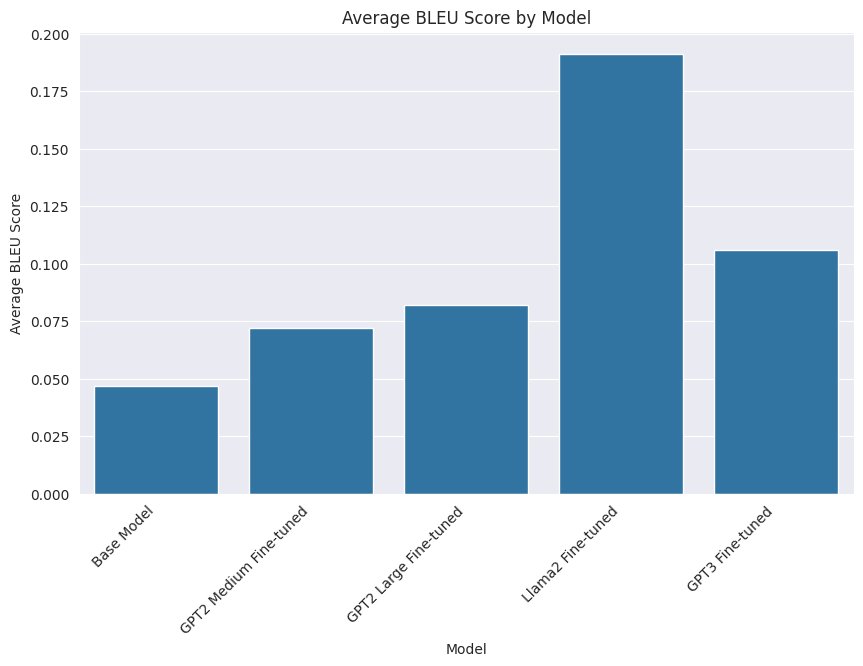

In [304]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Average BLEU Score', data=results_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Average BLEU Score by Model')
plt.show()

In [307]:
results_df['Average ROUGE-L Score F1'] = results_df['Average ROUGE-L Score'].apply(lambda x: x['f'])

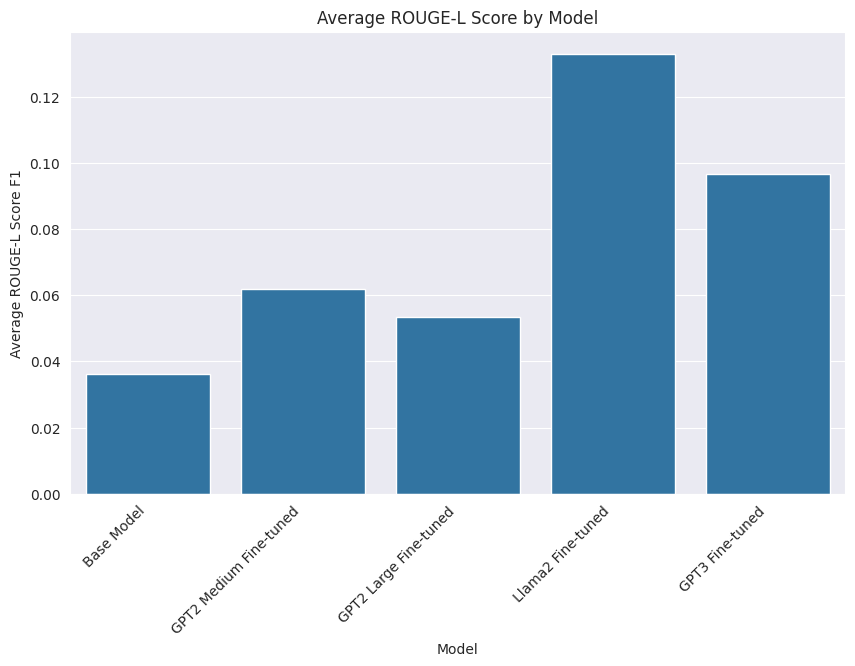

In [309]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Average ROUGE-L Score F1', data=results_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Average ROUGE-L Score by Model')
plt.show()

In [313]:
# Convert perplexity to scalar
results_df['Perplexity'] = results_df['Perplexity'].apply(lambda x: float(x))

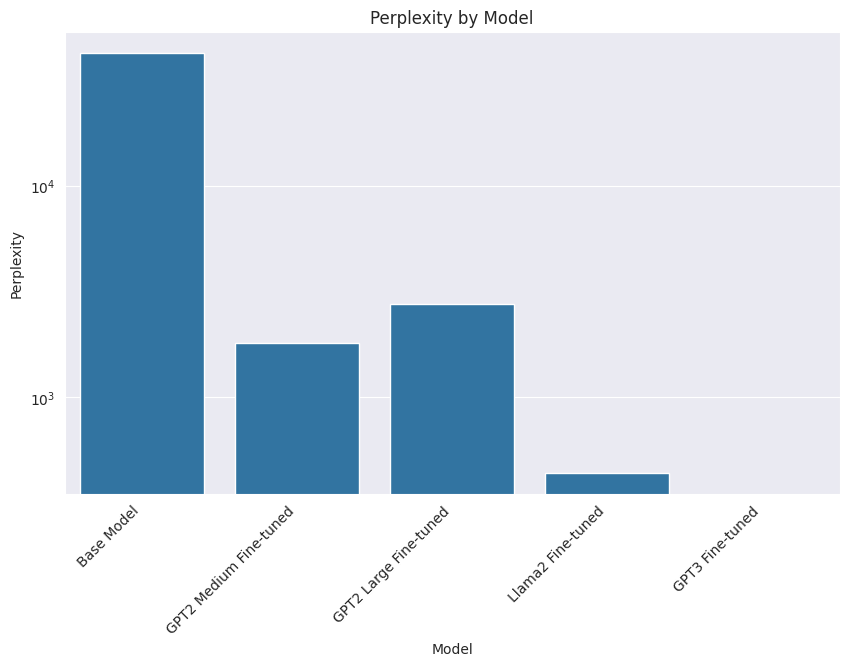

In [315]:
# Plot perplexity on log scale
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Perplexity', data=results_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Perplexity by Model')
ax.set_yscale('log')
plt.show()